# Reverse Time Migration using a vector veflectivity based acoustic wave equation

This tutorial will guide the reader through an implementation of a Reverse Time Migration (RTM) algorithm using an acoustic wave equation based on the vector reflectivity.

This tutorial is based on the following paper:

<br>**Seismic modeling with vector reflectivity** (2020)
<br>N. D. Whitmore, J. Ramos-Martinez, Y. Yang, and A. A. Valenciano
<br>SEG Technical Program Expanded Abstracts 2020
<br>https://doi.org/10.1190/segam2020-3424516.1



In [1]:
from examples.seismic.source import RickerSource, TimeAxis, PointSource
from examples.seismic.preset_models import Gardners
from examples.seismic.utils import setup_geometry
from examples.seismic import Model, Receiver
from examples.seismic.vector_reflectivity import VectorReflectivityAcousticWaveSolver

from devito import *

import numpy as np

import matplotlib.pyplot as plt

mpi4py is not available. You must install it


## Foward modelling

The acoustic wave equation can be rearranged to the following equation:

$$
m \frac{\partial^2 u}{\partial t^2} - \frac{1}{v_p} \nabla \cdot (v_p \nabla u) + 2\nabla \cdot(u\mathbf{R}) - 2u \nabla \cdot \mathbf{R} = S
$$

where $S = S(\mathbf{x}, t)$ is the source term, $v_p$ is the P-wave velocity, $\mathbf{R} = \dfrac{1}{2}\dfrac{\nabla z}{z}$ is the vector reflectivity and $z = v_p\rho$ is the acoustic impedance.

In [134]:
def vector_reflectivity_gardners(vp):
    b = Gardners(vp)
    z = vp/b
    Dzz = np.hstack((np.diff(z, axis=1), np.zeros((1,vp.shape[0])).T))
    Dxz = np.vstack((np.diff(z, axis=0), np.zeros(vp.shape[1])))
    r = [0.5 * Dzz/z, 0.5 * Dxz/z]

    return r

In [135]:
NX = 200
NZ = 120

SHAPE = (NX, NZ)
SPACING = (10., 10.)
ORIGIN = (0., 0.)
NLAYERS = 3
NBL = 50
SPACE_ORDER = 8
TIME_ORDER = 2
DTYPE = np.float32

# Model physical parameters:
vp = np.empty(SHAPE, dtype=DTYPE)

# Define a velocity profile. The velocity is in km/s
vp_top = 1.5
vp_bottom = 3.5
# define a velocity profile in km/s
vp[:] = vp_top  # Top velocity (background)
vp_i = np.linspace(vp_top, vp_bottom, NLAYERS)
for i in range(1, NLAYERS):
    vp[..., i*int(SHAPE[-1] / NLAYERS):] = vp_i[i]  # Bottom velocity

b = Gardners(vp, False)
r = vector_reflectivity_gardners(vp)

In [ ]:
# model = Model(vp=vp, r=r, origin=origin, space_order=space_order, shape=shape, dtype=dtype, spacing=spacing, nbl=nbl, bcs='damp')
model = Model(vp=vp, b=b, origin=ORIGIN, space_order=SPACE_ORDER, shape=SHAPE, dtype=DTYPE, spacing=SPACING, nbl=NBL, bcs='damp')

Operator `initdamp` ran in 0.01 s


In [137]:
# function to plot P wave velocit, and the x and z components of R
def img_model(img1, img2, img3, model, title=""):

    plt_options_model = {'cmap': 'jet', 'extent': [model.origin[0],
                         model.origin[0] + model.domain_size[0],
                         model.origin[1] + model.domain_size[1],
                         model.origin[1]]}

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))

    scale1 = np.max(img1)
    scale2 = np.min(img1)

    imag1 = ax[0].imshow(np.transpose(img1), vmin=scale1, vmax=scale2,
                         **plt_options_model)
    fig.colorbar(imag1, ax=ax[0])
    ax[0].set_title("Vp (km/s)", fontsize=20)
    ax[0].set_xlabel('z (m)', fontsize=20)
    ax[0].set_ylabel('x (m)', fontsize=20)
    ax[0].set_aspect('auto')

    scale3 = np.max(img2)
    scale4 = np.min(img2)

    imag2 = ax[1].imshow(np.transpose(img2), vmin=scale3, vmax=scale4,
                         **plt_options_model)
    fig.colorbar(imag2, ax=ax[1])
    ax[1].set_title("$R_x$ (m$^{-1}$)", fontsize=20)
    ax[1].set_xlabel('z (m)', fontsize=20)
    ax[1].set_ylabel('x (m)', fontsize=20)
    ax[1].set_aspect('auto')

    scale5 = np.max(img3)
    scale6 = np.min(img3)

    imag3 = ax[2].imshow(np.transpose(img3), vmin=scale5, vmax=scale6,
                         **plt_options_model)
    fig.colorbar(imag3, ax=ax[2])
    ax[2].set_title(r"$R_z$ (m$^{-1}$)", fontsize=20)
    ax[2].set_xlabel('z (m)', fontsize=20)
    ax[2].set_ylabel('x (m)', fontsize=20)
    ax[2].set_aspect('auto')

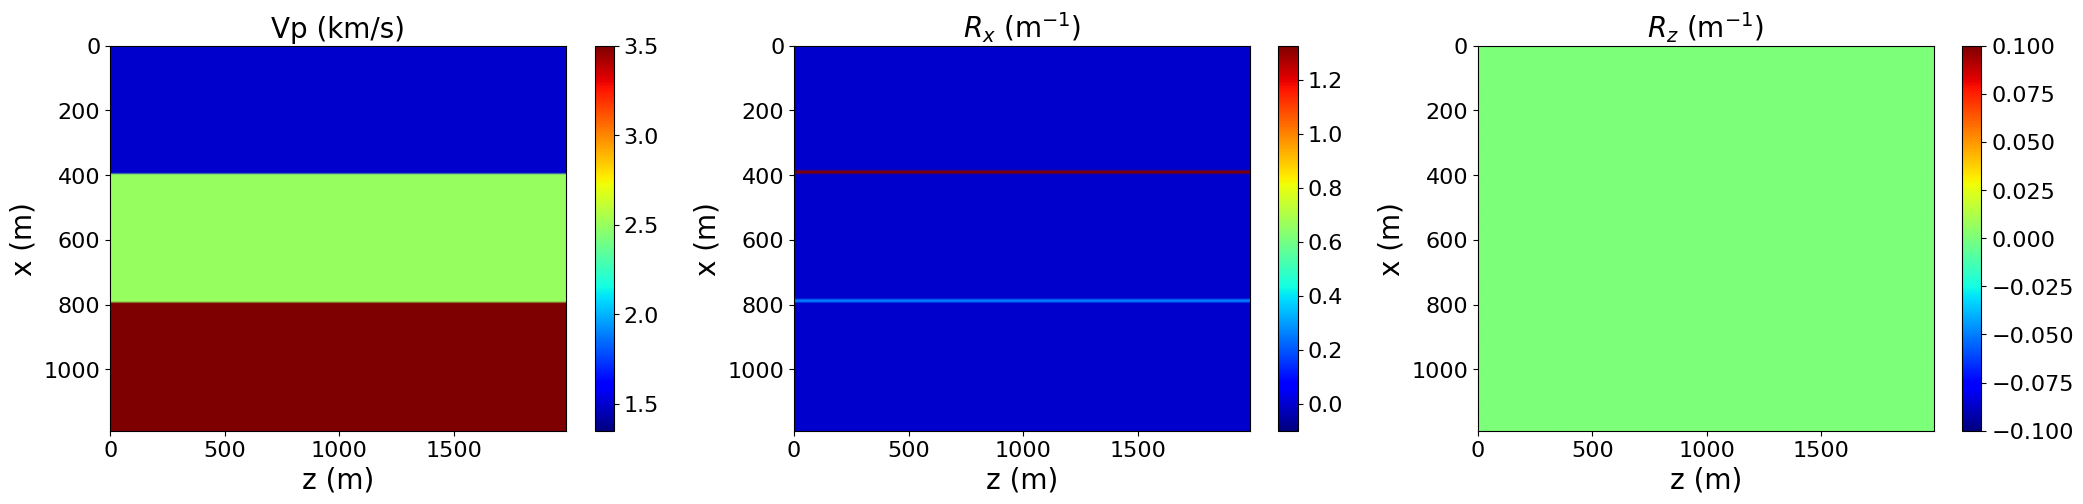

In [138]:
img_model(vp, r[0], r[1], model)

In [139]:
f0 = 0.020  # peak/dominant frequency
# f0 = 0.010  # peak/dominant frequency

s = model.grid.stepping_dim.spacing
damp = model.damp

# Time step in ms and time range:
t0, tn = 0., 1800.
dt = model.critical_dt
time_range = TimeAxis(start=t0, stop=tn, step=dt)

geometry = setup_geometry(model, tn, f0=f0)
geometry = geometry.resample(dt)

In [140]:
# Function that define source and receiver parameters
def source_rec_term(model, u, pos):
    src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time_range)
    src.coordinates.data[0, :] = pos[0]  # position of source in offset
    src.coordinates.data[0, -1] = pos[1]  # position of source in depth

    # Create symbol for receivers
    rec = Receiver(name='rec', grid=model.grid, npoint=model.shape[0],
                   time_range=time_range)

    rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=model.shape[0])
    # postion of receiver at 400 m of depth for pressure field
    rec.coordinates.data[:, 1] = 10.
    
    src_term = src.inject(field=u.forward, expr=src * s**2/model.m)

    rec_term = rec.interpolate(expr=u)

    return rec, rec_term, src_term, src

## The forward operator

In [141]:
def forward(model, pos, geometry):
    u = TimeFunction(name='u', grid=model.grid, save=geometry.nt, time_order=TIME_ORDER,
                            space_order=SPACE_ORDER)

    m = model.m
    r = model.r
    vp = model.vp

    pde = m * u.dt2 - 1/vp * div(vp*grad(u, .5), -.5) + 2 * div(u * r,-.5) - 2 * u * div(r, -.5) + model.damp * u.dt
    stencil = Eq(u.forward, solve(pde, u.forward))

    rec, rec_term, src_term, src = source_rec_term(model, u, pos)

    op = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
    # op(dt=dt, src=src, rec=rec, vp=vp, r_x=r[0], r_y=r[1])
    op(dt=dt)
    
    return u, rec

In [142]:
# generating a shot with the source in the center of the model

pos = np.empty((1, 2), dtype=np.float32)
pos[0, 0] = model.domain_size[0] * .5

u, rec = forward(model, pos[0], geometry)

Operator `Kernel` ran in 0.69 s


In [143]:
# u.data.tofile('temp.bin')

In [144]:
u.data.shape

(1215, 300, 220)

In [145]:
# model.r

In [146]:
# solver = VectorReflectivityAcousticWaveSolver(model, geometry, space_order=space_order)
# _, rec, _ = solver.forward()

## Plotting shot data

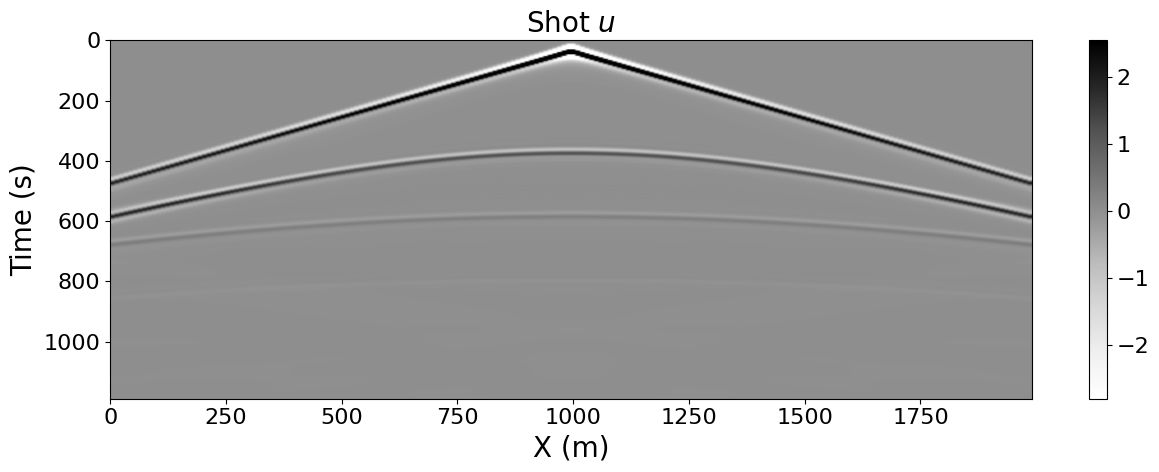

In [147]:
# NBVAL_IGNORE_OUTPUT
slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]

aspect_ratio = model.shape[0]/model.shape[1]

plt_options_model = {'cmap': 'Greys', 'extent': [model.origin[0], model.origin[0] +
                                                 model.domain_size[0],
                                                 model.origin[1] +
                                                 model.domain_size[1],
                                                 model.origin[1]]}
fig, ax = plt.subplots(figsize=(13, 5))

scale = np.max(rec.data) / 10.

img1 = ax.imshow(rec.data, vmin=scale, vmax=-scale, **plt_options_model)
fig.colorbar(img1, ax=ax)
ax.set_title(r"Shot $u$", fontsize=20)
ax.set_xlabel('X (m)', fontsize=20)
ax.set_ylabel('Time (s)', fontsize=20)
ax.set_aspect('auto')

plt.tight_layout()

## Plotting wavefields snapshots

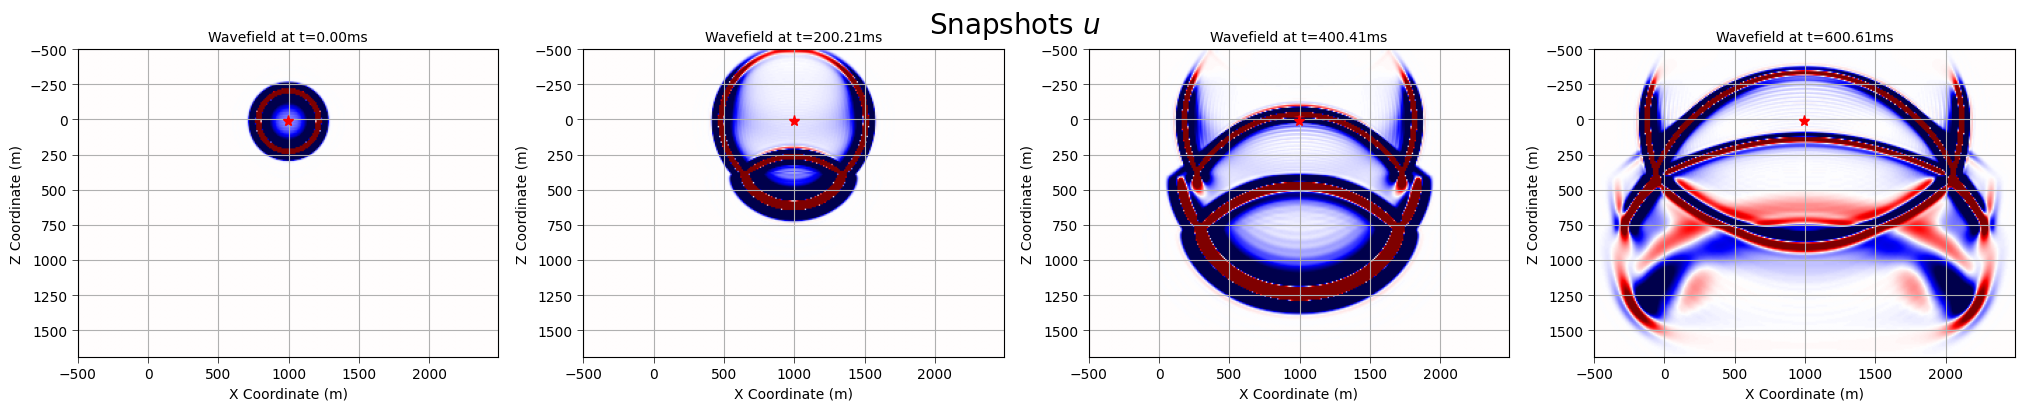

In [148]:
# NBVAL_IGNORE_OUTPUT
# Some useful definitions for plotting if nbl is set to any other value than zero
shape_pad = np.array(SHAPE) + 2 * NBL
origin_pad = tuple([o - s*NBL for o, s in zip(ORIGIN, SPACING)])
extent_pad = tuple([s*(n-1) for s, n in zip(SPACING, shape_pad)])
# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]


def plot_wavefield(a, title=None):
    # Plot the wavefields, each normalized to scaled maximum of last time step
    kt = (time_range.num - 2) - 1
    amax = 10 * np.max(np.abs(a.data[kt, :, :]))

    nsnaps = 9
    factor = round(time_range.num / nsnaps)

    fig, axes = plt.subplots(1, 4, figsize=(25, 4), sharex=True)
    fig.suptitle(title, size=20)
    for count, ax in enumerate(axes.ravel()):
        snapshot = factor * (count + 1)
        ax.imshow(np.transpose(a.data[snapshot, :, :]), cmap="seismic", vmin=-amax,
                  vmax=+amax, extent=plt_extent)
        ax.plot(model.domain_size[0] * .5, 10, 'red', linestyle='None', marker='*',
                markersize=8, label="Source")
        ax.grid()
        ax.tick_params('both', length=4, width=0.5, which='major', labelsize=10)
        ax.set_title("Wavefield at t=%.2fms" % (factor*count*dt), fontsize=10)
        ax.set_xlabel("X Coordinate (m)", fontsize=10)
        ax.set_ylabel("Z Coordinate (m)", fontsize=10)


plot_wavefield(u, title="Snapshots $u$")

## The adjoint operator

The adjoint operator solves the adjoint of the wave equation used in the modelling step with the receiver signal acting as the source term. The wave field is computed backwards in time, starting from the its state in final time $t = t_n$ and calculating the field in each timestep until the initial time $t = 0$. The adjoint wave equation in terms of the vector reflectivity is

$$
m\frac{\partial^2 v}{\partial dt} - \nabla \cdot \left[ v_p \nabla\left( \frac{1}{v_p} v \right) \right] + 2 \mathbf{R} \cdot \nabla v - 2v \nabla \cdot \mathbf{R} = R
$$

where $v$ is the adjoint pressure field (the wave field) and $R$ is the adjoint source, which stores the receiver signal.

In [149]:
def adjoint(model, geometry, rec):
    v = TimeFunction(name='v', grid=model.grid, save=geometry.nt, time_order=TIME_ORDER,
                    space_order=SPACE_ORDER)
    
    m = model.m
    vp = model.vp
    r = model.r

    pde = m * v.dt2 - div(vp * grad(v/vp, .5), -.5) - 2 * r.T * grad(v, .5) - 2 * v * div(r, -.5) + model.damp * v.dt.T
    stencil = [Eq(v.backward, solve(pde, v.backward))]

    rec_term = rec.inject(v.backward, expr = rec * s**2 / m)


    op = Operator(stencil + rec_term, subs=model.spacing_map)
    op(dt=dt)
    return v

In [150]:
v = adjoint(model, geometry, rec)

Operator `Kernel` ran in 0.78 s


## Imaging condition

We will use Claerbout's imaging condition where the image is constructed by cross-correlating the forward $u$ and adjoint $v$ wavefields in time:

$$
I = \int_0^{t_n} u(t)v(t) dt
$$

In order to compensate the lower energy carried by incident waves to reflectors at lower depths, we will also divide the final image componentwise by the source illumination:

$$
I = \frac{\int_0^{t_n} u(x, z, t)v(x, z, t) dt}{\int_0^{t_n} u(x, z, t)^2 dt}
$$

In [153]:
def imaging_condition(u: np.ndarray, v: np.ndarray, cumulative = False) -> np.array:
    H = np.sum(u**2, axis=0)

    if cumulative:
        return np.cumsum(u * v, axis=0) / (H + 1e-9)
    else:
        return np.sum(u * v, axis=0) / (H + 1e-9)

## Reverse-Time Migration

In [154]:
NSHOTS = 10
source_locations = np.empty((NSHOTS, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., model.shape[0]*model.spacing[0],
                                     num=NSHOTS)
source_locations[:, 1] = 10.


def img_final(model, geometry, cumulative = False):
    if cumulative:
        imf = TimeFunction(name="imf", grid=model.grid, space_order=SPACE_ORDER, time_order=TIME_ORDER, save=geometry.nt)
    else:
        imf = Function(name="imf", grid=model.grid, space_order=SPACE_ORDER)

    for i in range(NSHOTS):
        print('Imaging source %d out of %d' % (i+1, NSHOTS))
        pos = source_locations[i, :]
        
        u, rec = forward(model, pos, geometry)
        v = adjoint(model, geometry, rec)
        imf.data[:] += imaging_condition(u.data, v.data, cumulative)
        # imf_2 += imaging_condition(u.data, v.data)

        # op_imaging = ImagingOperator(model, imf, u, rec)
        # op_imaging(dt=dt)

        # op_imaging = ImagingOperator_alt(model, geometry)
        # op_imaging(u=u, v=v, imf=imf)

        # for i in range(u.shape[0]):
        #     imf_2 += u.data[i] * v.data[i]

    # imf.data[:] = imf_2
    return imf

In [155]:
imf_adj = img_final(model, geometry)

Imaging source 1 out of 10


Operator `Kernel` ran in 0.66 s
Operator `Kernel` ran in 0.58 s


Imaging source 2 out of 10


Operator `Kernel` ran in 0.56 s
Operator `Kernel` ran in 0.60 s


Imaging source 3 out of 10


Operator `Kernel` ran in 0.56 s
Operator `Kernel` ran in 0.61 s


Imaging source 4 out of 10


Operator `Kernel` ran in 0.55 s
Operator `Kernel` ran in 0.65 s


Imaging source 5 out of 10


Operator `Kernel` ran in 0.58 s
Operator `Kernel` ran in 0.60 s


Imaging source 6 out of 10


Operator `Kernel` ran in 0.56 s
Operator `Kernel` ran in 0.62 s


Imaging source 7 out of 10


Operator `Kernel` ran in 0.55 s
Operator `Kernel` ran in 0.65 s


Imaging source 8 out of 10


Operator `Kernel` ran in 0.63 s
Operator `Kernel` ran in 0.61 s


Imaging source 9 out of 10


Operator `Kernel` ran in 0.56 s
Operator `Kernel` ran in 0.61 s


Imaging source 10 out of 10


Operator `Kernel` ran in 0.60 s
Operator `Kernel` ran in 0.60 s


In [156]:
# Plotting for final image
def img(img, model, title=""):
    slices = [slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl)]

    plt_options_model = {'cmap': 'Greys', 'extent': [model.origin[0], model.origin[0]
                                                     + model.domain_size[0],
                                                     model.origin[1] +
                                                     model.domain_size[1],
                                                     model.origin[1]]}
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

    scale = np.max(img.data[slices])

    img1 = ax.imshow(np.transpose(img.data[slices]), vmin=scale, vmax=-scale,
                        **plt_options_model)
    fig.colorbar(img1, ax=ax)
    ax.set_title(title + "$I$", fontsize=20)
    ax.set_xlabel('z (m)', fontsize=20)
    ax.set_ylabel('x (m)', fontsize=20)
    ax.set_aspect('auto')

    # plt.savefig('Elastic' + title + '.pdf')

In [ ]:
def lapla(model, image):
    lapla = Function(name='lapla', grid=model.grid, space_order=SPACE_ORDER)
    stencil = Eq(lapla, -image.laplace)
    op = Operator([stencil])
    op.apply()
    return lapla

In [159]:
trueR = Function(name='trueR', space_order=SPACE_ORDER, grid=model.grid)
Operator(Eq(trueR, sqrt(model.r[0] * model.r[0] + model.r[1] * model.r[1])))()


Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000289, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Operator `Kernel` ran in 0.01 s


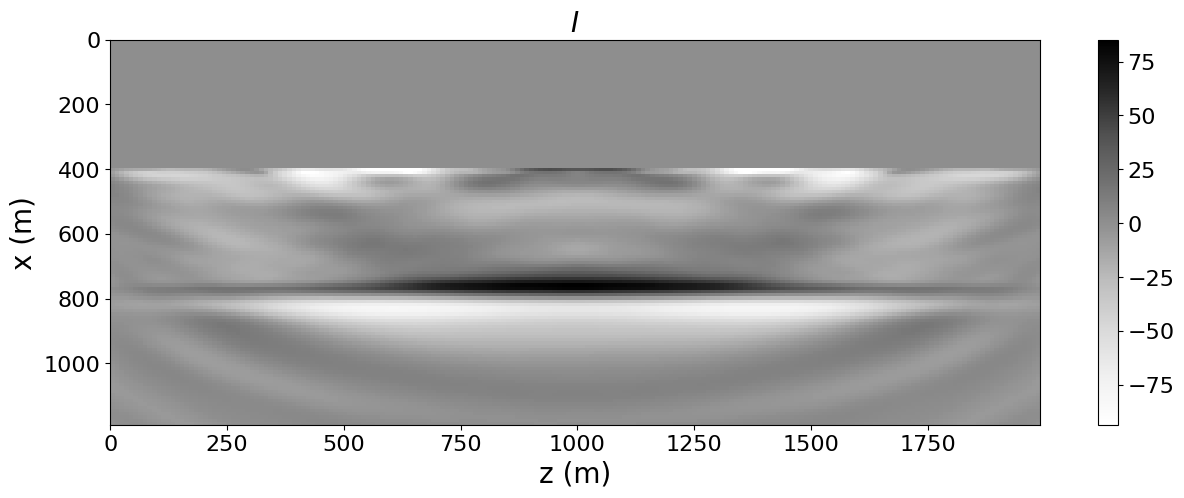

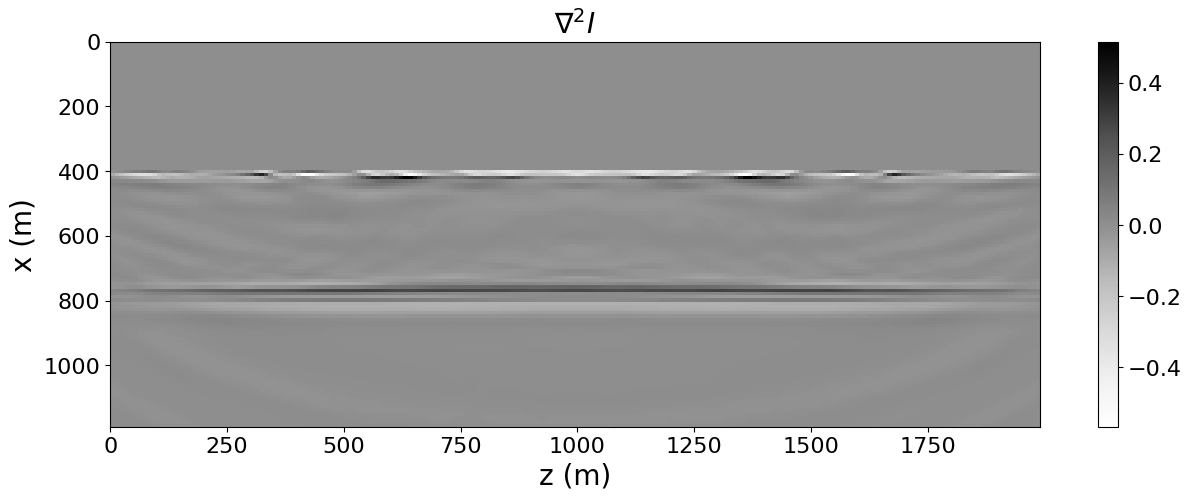

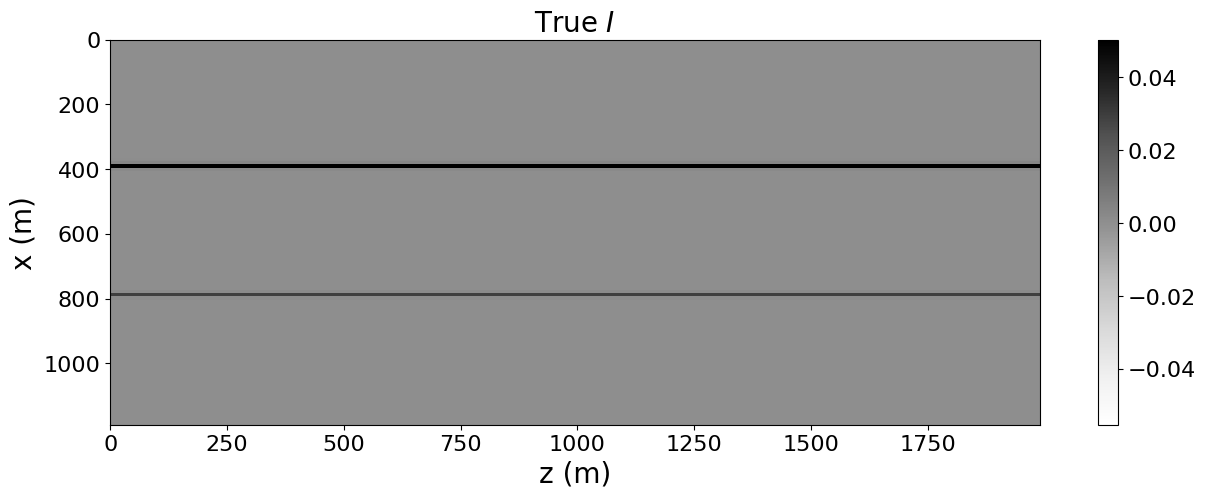

In [160]:
# Applying laplacian filter
image_final_adj = lapla(model, imf_adj)

# Doing zero the water layer

imf_adj.data[:, :90] = 0.
image_final_adj.data[:, :90] = 0.

img(imf_adj, model, title="")
img(image_final_adj, model, title="$\\nabla^2$")
img(trueR, model, title="True ")

In [161]:
imf_cum_adj = img_final(model, geometry, True)

Imaging source 1 out of 10


Operator `Kernel` ran in 0.67 s
Operator `Kernel` ran in 0.61 s


Imaging source 2 out of 10


Operator `Kernel` ran in 0.63 s
Operator `Kernel` ran in 0.53 s


Imaging source 3 out of 10


Operator `Kernel` ran in 0.54 s
Operator `Kernel` ran in 0.51 s


Imaging source 4 out of 10


Operator `Kernel` ran in 0.51 s
Operator `Kernel` ran in 0.57 s


Imaging source 5 out of 10


Operator `Kernel` ran in 0.54 s
Operator `Kernel` ran in 0.59 s


Imaging source 6 out of 10


Operator `Kernel` ran in 0.50 s
Operator `Kernel` ran in 0.57 s


Imaging source 7 out of 10


Operator `Kernel` ran in 0.54 s
Operator `Kernel` ran in 0.59 s


Imaging source 8 out of 10


Operator `Kernel` ran in 0.55 s
Operator `Kernel` ran in 0.60 s


Imaging source 9 out of 10


Operator `Kernel` ran in 0.55 s
Operator `Kernel` ran in 0.58 s


Imaging source 10 out of 10


Operator `Kernel` ran in 0.51 s
Operator `Kernel` ran in 0.58 s


In [162]:
imf_cum_adj.data[:, :, :90] = 0.

In [176]:
time_range.num

1215

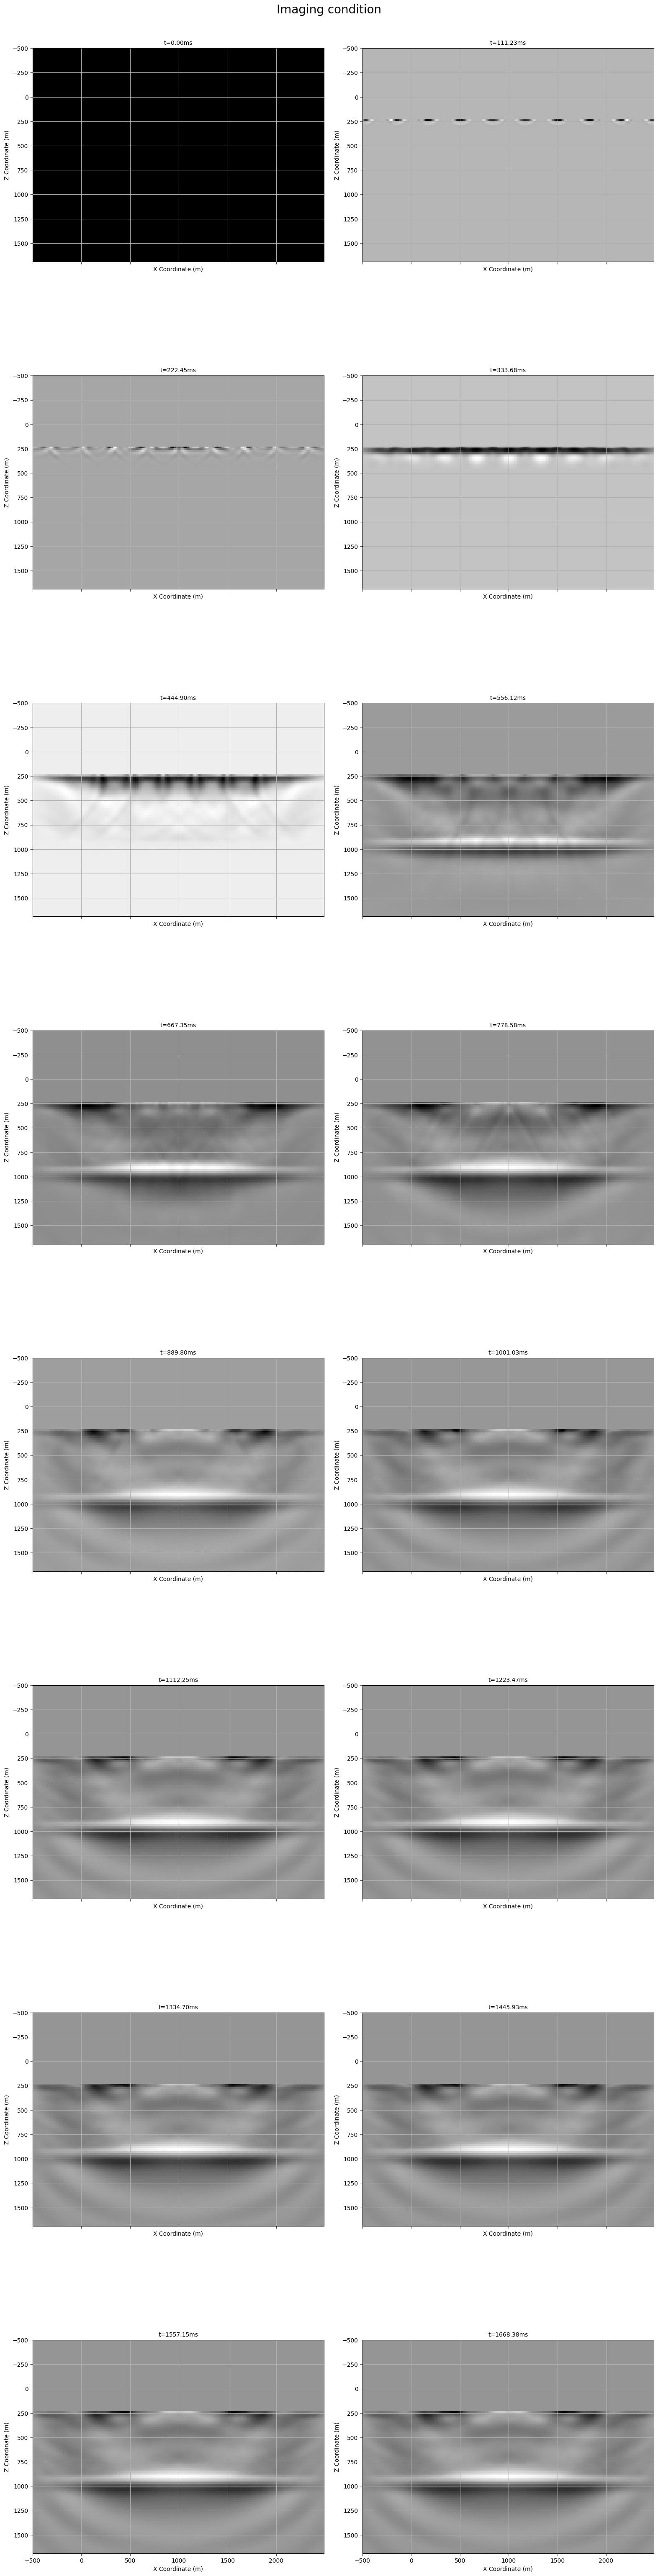

In [213]:
# NBVAL_IGNORE_OUTPUT
# Some useful definitions for plotting if nbl is set to any other value than zero
shape_pad = np.array(SHAPE) + 2 * NBL
origin_pad = tuple([o - s*NBL for o, s in zip(ORIGIN, SPACING)])
extent_pad = tuple([s*(n-1) for s, n in zip(SPACING, shape_pad)])
# Note: flip sense of second dimension to make the plot positive downwards
plt_extent = [origin_pad[0], origin_pad[0] + extent_pad[0],
              origin_pad[1] + extent_pad[1], origin_pad[1]]


def plot_image_condition(a, nsnaps = 4, title=None):
    # Plot the wavefields, each normalized to scaled maximum of last time step
    kt = (time_range.num - 2) - 1
    amax = 10 * np.max(a.data[kt, :, :])
    amin = 10 * np.max(a.data[kt, :, :])

    slc = slice(model.nbl, -model.nbl)
    
    nrows = int(np.ceil(nsnaps / 2))

    factor = int(np.ceil(time_range.num / nsnaps)) - 1

    fig, axes = plt.subplots(nrows, 2, sharex=True, figsize=(16,8*nrows))
    fig.suptitle(title, size=20)

    for count, ax in enumerate(axes.ravel()):
        # snapshot = factor * (count + 1)
        if count >= nsnaps:
            break
        snapshot = factor * count
        ax.imshow(np.transpose(a.data[snapshot, slc, slc]), cmap="grey", extent=plt_extent)
        # ax.plot(model.domain_size[0] * .5, 10, 'red', linestyle='None', marker='*',
        #         markersize=8, label="Source")
        ax.grid()
        ax.tick_params('both', length=4, width=0.5, which='major', labelsize=10)
        ax.set_title("t=%.2fms" % (factor*count*dt), fontsize=10)
        ax.set_xlabel("X Coordinate (m)", fontsize=10)
        ax.set_ylabel("Z Coordinate (m)", fontsize=10)
    
    fig.tight_layout()


plot_image_condition(imf_cum_adj, 16, title="Imaging condition")

In [164]:
geometry.tn

1800.0

## `VectorFunction` initialization

In [ ]:
# from devito import VectorFunction, Grid, Function, grad

# shape = (5, 5)

# grid = Grid(shape, extent=(1, 1), origin=(0.,0.))

# d1 = np.random.random(shape)
# d2 = np.ones(shape)

# vec_func1 = Function(name='vecfunc1', grid=grid, space_order=2)
# vec_func1.data[:] = d1
# vec_func2 = Function(name='vecfunc2', grid=grid, space_order=2)
# vec_func2.data[:] = d2
# vec_func = VectorFunction(name='vecfunc', grid=grid, space_order=2, components=[vec_func1, vec_func2])
# func = Function(name='func', grid=grid, space_order=2)

In [ ]:
# grad(func)
# vec_func